# Model Deployment
The purpose of the model deployment phase in a model development process is to take a trained and validated machine learning model and make it available for use in a real-world environment. This phase involves integrating the model into production systems so it can generate predictions on new, unseen data. The main goals are:

- Operationalizing the model so it can be accessed by end-users, applications, or business processes.
- Ensuring the model runs efficiently, reliably, and securely in the target environment.
- Monitoring the model’s performance over time to detect data drift or performance degradation.
- Enabling updates, retraining, or rollback as needed based on new data or requirements.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import os
import rich

In [2]:
version_tag = "dev"

## Load Data And Base Model

In [3]:
## Load data
input_folder = "../.local/analysis_pipeline/data_exploration"
inference_data = pd.read_parquet(f"{input_folder}/inference_data_{version_tag}.parquet")

## Load model
from xgboost import XGBRegressor
input_folder = "../.local/analysis_pipeline/model_selection"
model = XGBRegressor()
model.load_model(f"{input_folder}/xgb_tweedie_model_tuned_{version_tag}.json")

## Predict On The Inference Data

In [4]:
# Import xgboost for model prediction (not strictly needed for XGBRegressor, but kept for reference)
import xgboost as xgb

# Define the list of predictor variables (should match those used in model training)
veh_pred_lst = ['veh_value', 'veh_body', 'veh_age', 'engine_type', 'max_power', 'veh_color']
policy_pred_lst = ['gender', 'agecat', 'e_bill' ]
driving_behavior_pred_lst = ['area', 'time_of_week_driven', 'time_driven']
demo_pred_lst = ['marital_status', 'low_education_ind', 'credit_score', 'driving_history_score']
pred_lst = veh_pred_lst + policy_pred_lst + driving_behavior_pred_lst + demo_pred_lst

# Select the predictor columns from the inference data
X = inference_data[pred_lst].copy()

# Convert object columns to 'category' dtype if needed (for compatibility, especially if used during training)
for col in pred_lst:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')

# Predict using the loaded XGBRegressor model
pred = model.predict(X)

# Store the predictions in a new column in the inference_data DataFrame
inference_data['xgb_tweedie_pred'] = pred

## Sign risk levels to the quotes

In [5]:
# Ensure the parent directory is in the path for module import
import sys
sys.path.append(os.path.abspath(".."))
from analysis_tool_chest.data_exploration import PredictivenessCheck

# Select training samples for predictiveness check
data = inference_data

# Define variables
exp_var = 'exposure'
pred_var = 'xgb_tweedie_pred'
var_1 = 'xgb_tweedie_pred'
var_2 = None
nbins = 10


# Create and run PredictivenessCheck
pc = PredictivenessCheck(
    df=data,
    pred_var=pred_var,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2
)

# Assign risk bins to quotes in the inference data
pc.binning(nbins=nbins)
processed_inference_data = pc.binned_data

## Inference Via Top Reasons

In [6]:
pred_lst_by_var_imp = ['low_education_ind', 'veh_body', 'credit_score', 'veh_age', 'driving_history_score', 'engine_type', 
                       'veh_color', 'max_power', 'time_driven', 'marital_status', 'veh_value', 'area', 'e_bill', 'agecat', 
                       'gender', 'time_of_week_driven']

In [ ]:
from analysis_tool_chest.data_exploration import PredictivenessCheckList

# Example setup
data = processed_inference_data
exp_var = 'veh_cnt' 
var_1 = 'xgb_tweedie_pred'     
var_2 = None   
nbins = 5         

# Create and run the PredictivenessCheckList
pcl = PredictivenessCheckList(
    data=data,
    pred_var_lst=pred_lst_by_var_imp,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2,     
    nbins=nbins
)

pcl.run_all()
pcl.plot_all(var_1_color='red')

In [8]:
# processed_inference_data.loc[processed_inference_data['bin']==9, :]
processed_inference_data.loc[processed_inference_data['id']==55, :].transpose()

,9784
id,55
veh_value,6.81
exposure,0.233427
veh_body,SUV
veh_age,4
gender,F
area,E
agecat,4
engine_type,hybrid
max_power,152


#### Analysis on id 55
- low_education_ind         = 1         -> <span style="color:red"><b><i>    $100 -> Education level is low                          </i></b></span>
- veh_body                  = SUV       -> <span style="color:red"><b><i>    $150 -> SUV vehicle type                                </i></b></span>
- credit_score              = 646.5     -> <span style="color:green"><b><i>  $-40 -> Credit score is not low                         </i></b></span>
- driving_history_score     = 71        -> <span style="color:red"><b><i>    $120 -> Driving history score is low                    </i></b></span>
- veh_color                 = white     -> <span style="color:red"><b><i>    $ 30 -> Vehicle color is white                          </i></b></span>

<span style="color:red"><b><i>Task 6: Use SHAP values and Waterfall plots to derive top reaons for individual quote and/or global predictor contributions. Specific to-dos are </i></b></span>
1. <span style="color:red"><b><i>Read and summarize the paper: https://arxiv.org/abs/1705.07874.</i></b></span>
2. <span style="color:red"><b><i>Read and try the SHAP value method described in this blog: https://samuel-book.github.io/samuel_shap_paper_1/xgb_10_features/03_xgb_combined_shap_key_features.html. Note that we only need to handle individual case. Global predictor impact session and other sessions are beneficial but not necessary. </i></b></span>

### Task 6: Use SHAP Values and Waterfall plots

SHAP is a method for explaining machine learning models that provides clear, consistent feature importance values for individual predictions. Instead of relying on a single algorithm-specific trick, like LIME, DeepLIFT, LRP, and Shapley sampling, the authors show that all of these existing techniques fall into the family of methods called additive feature attibution models. The authors then prove that within this family, only one attribution method satisfies three desirable properties, local accuracy, consistency and  missingness. That unique solution is the Shapley value from cooperative game theory. The authors build SHAP by connecting Shapley values to model explanations. Shapley Values measure contribution by averaging a features marginal contribution across all possible subsets of other features, but since most models can't handle arbitrary missing inputs, the author approximates these subsets with conditional expectations. This allows shap connect to classic shapley regression values, model-agnostic explanations, and gradient/ deep-learning explanation methods. Because exact Shapley values are computationally expensive, the paper also introduces some practical approximation methods. For example, Kernel SHAP is a model-agnostic version that combines ideas from LIME with a kernel derived from Shapely theory and Deep SHAP extends this to deep learning by combining Shapley values with DeepLIFT's backpropogation. The experiments highlight the benefits of SHAP. Kernel SHAP is more efficient and alignt better with human intuition in user studies. Deep SHAP gives cleaner and more accurate attribution maps for CNNs on MNIST compared to LIME and DeepLIFT. Overall, the SHAP framework is a theoretically grounded and practical way to interpret complex machine learning models. For competitions, SHAP is valuable because it offers consistent, intuitive explanations for individual predictions and works well across many model types, including XGBoost and neural networks. This makes it useful both for debugging models and for communicating why certain predictions were made.

In [36]:
import shap
import matplotlib.pyplot as plt

In [37]:
# Make numeric copies of X for SHAP
X_shap = X.copy()

for col in X_shap.columns:
    if pd.api.types.is_categorical_dtype(X_shap[col]):
        X_shap[col] = X_shap[col].cat.codes
    elif X_shap[col].dtype == 'object':
        X_shap[col] = X_shap[col].astype('category').cat.codes

# enforce float64
X_shap = X_shap.astype(float)

/var/folders/dg/30598mg92052n07ffckfznw40000gn/T/ipykernel_4265/2953013522.py:5: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X_shap[col]):


In [38]:
# Create a TreeExplainer for the model
explainer = shap.TreeExplainer(model, feature_perturbation='tree_path_dependent')

In [39]:
# Compute SHAP values for all rows in X
shap_values = explainer(X_shap)

In [40]:
# Inspect top reasons for quote 55
quote_id = 55
row_idx = inference_data.index[inference_data['id'] == quote_id]
ix = row_idx[0]

instance_X = X_shap.iloc[[ix]]  
instance_shap = shap_values[ix]

In [43]:
# Extract SHAP values
vals = instance_shap.values

shap_contrib = pd.Series(
    vals,
    index=pred_lst
).sort_values(key=np.abs, ascending=False)

print(shap_contrib.head(10))

veh_body                 0.284107
engine_type             -0.156149
area                    -0.151338
veh_color               -0.132702
veh_value               -0.115382
max_power                0.081733
driving_history_score    0.068408
low_education_ind       -0.066229
credit_score             0.065886
gender                  -0.056490
dtype: float32


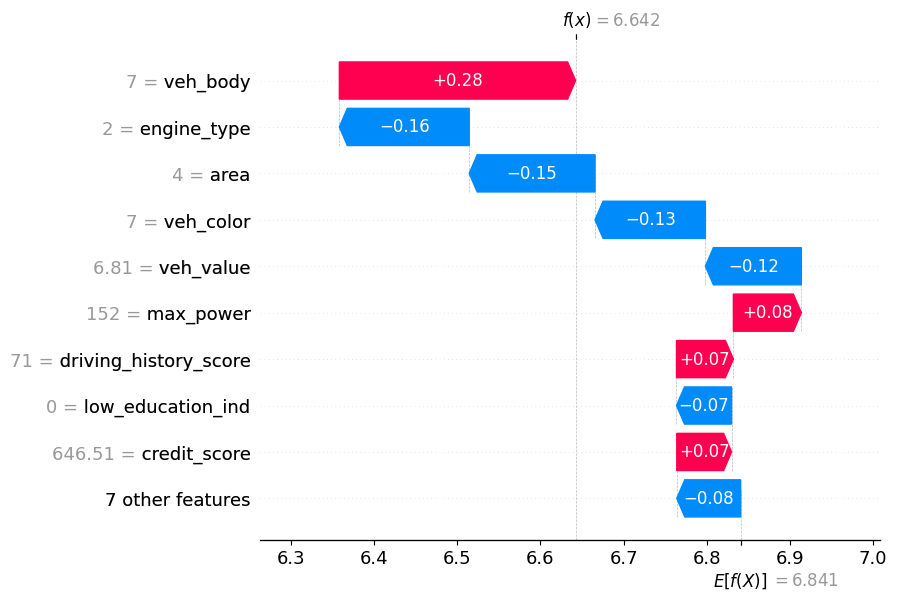

In [42]:
# Waterfall plot for that single quote
shap.plots.waterfall(instance_shap, max_display=10)
plt.show()

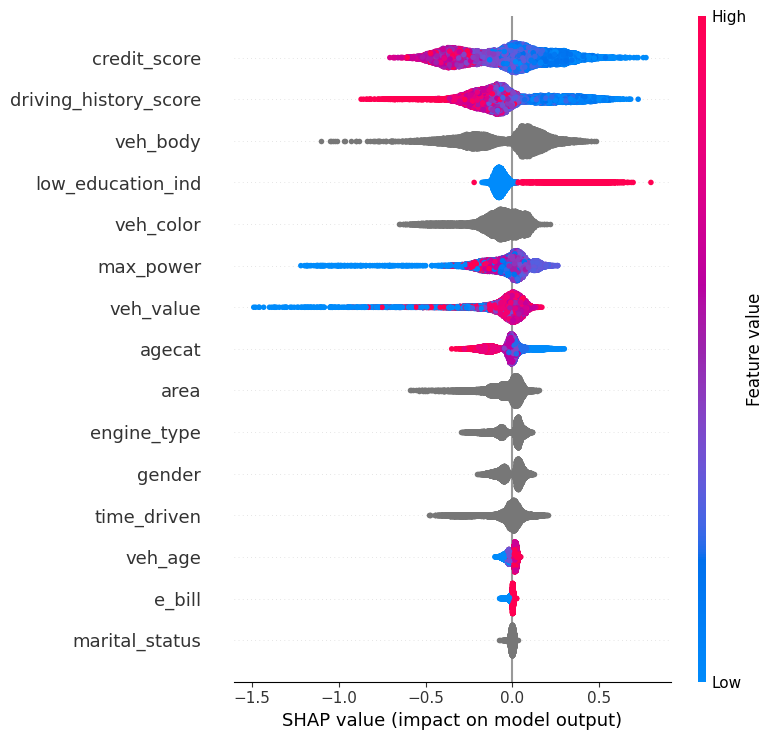

In [33]:
# Global SHAP summary for all quotes
shap.summary_plot(
    shap_values=shap_values.values,
    features=X,
    feature_names=pred_lst,
    max_display=15
)
plt.show()